Found 388 images belonging to 2 classes.
Epoch 1/10
10/10 [==============================] - 12s 810ms/step - loss: 0.6905 - accuracy: 0.5466
Epoch 2/10
10/10 [==============================] - 7s 681ms/step - loss: 0.6394 - accuracy: 0.6977
Epoch 3/10
10/10 [==============================] - 5s 550ms/step - loss: 0.5922 - accuracy: 0.7267
Epoch 4/10
10/10 [==============================] - 6s 555ms/step - loss: 0.5636 - accuracy: 0.7138
Epoch 5/10
10/10 [==============================] - 6s 585ms/step - loss: 0.5354 - accuracy: 0.7299
Epoch 6/10
10/10 [==============================] - 5s 502ms/step - loss: 0.4861 - accuracy: 0.7910
Epoch 7/10
10/10 [==============================] - 7s 712ms/step - loss: 0.4511 - accuracy: 0.8135
Epoch 8/10
10/10 [==============================] - 6s 565ms/step - loss: 0.4466 - accuracy: 0.7974
Epoch 9/10
10/10 [==============================] - 5s 526ms/step - loss: 0.4123 - accuracy: 0.8135
Epoch 10/10
3/3 [==============================] - 0s 94ms

Epoch 1/10
5/5 [==============================] - 8s 582ms/step - loss: 0.5710 - accuracy: 0.6284
Epoch 2/10
5/5 [==============================] - 2s 482ms/step - loss: 0.3977 - accuracy: 0.7770
Epoch 3/10
5/5 [==============================] - 3s 550ms/step - loss: 0.2795 - accuracy: 0.8919
Epoch 4/10
5/5 [==============================] - 3s 730ms/step - loss: 0.1687 - accuracy: 1.0000
Epoch 5/10
5/5 [==============================] - 3s 560ms/step - loss: 0.0853 - accuracy: 1.0000
Epoch 6/10
5/5 [==============================] - 3s 524ms/step - loss: 0.0418 - accuracy: 1.0000
Epoch 7/10
5/5 [==============================] - 3s 519ms/step - loss: 0.0167 - accuracy: 1.0000
Epoch 8/10
5/5 [==============================] - 3s 482ms/step - loss: 0.0081 - accuracy: 1.0000
Epoch 9/10
5/5 [==============================] - 3s 508ms/step - loss: 0.0040 - accuracy: 1.0000
Epoch 10/10
2/2 [==============================] - 0s 37ms/step
Local Model 5 Train Accuracy: 100.00%
Local Model 5 Tr

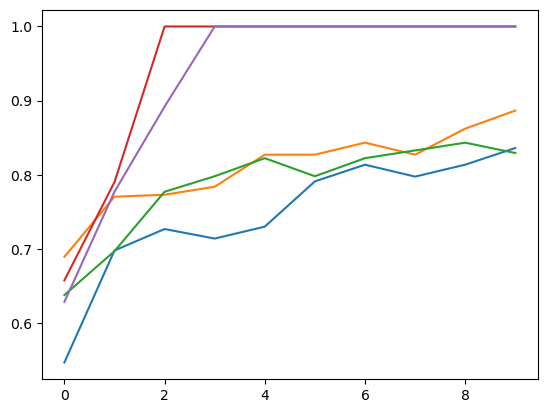

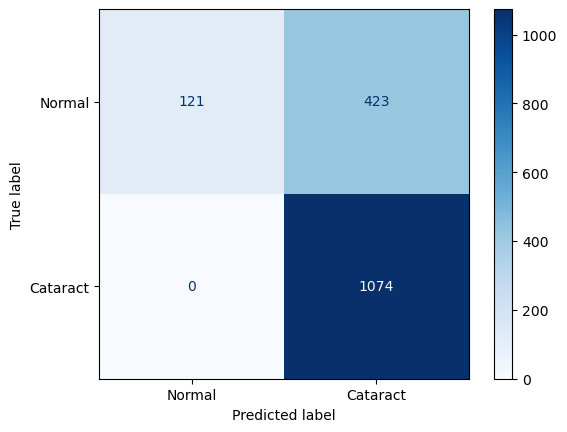

51/51 [==============================] - 6s 125ms/step
Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      0.22      0.36       544
    Cataract       0.72      1.00      0.84      1074

    accuracy                           0.74      1618
   macro avg       0.86      0.61      0.60      1618
weighted avg       0.81      0.74      0.68      1618

51/51 [==============================] - 6s 120ms/step
Global Model Train Accuracy: 73.86%
Global Model Train Precision: 0.72
Global Model Train Recall: 1.00
Global Model Train F1-score: 0.84

51/51 [==============================] - 6s 127ms/step
Global Model Test Accuracy: 73.86%
Global Model Test Precision: 0.72
Global Model Test Recall: 1.00
Global Model Test F1-score: 0.84



In [3]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Define the CNN model
def create_cnn_model():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define a function to load data from a local dataset
def load_data(client_folder):
    datagen = ImageDataGenerator(rescale=1./255)
    
    data_generator = datagen.flow_from_directory(
        client_folder,
        target_size=(128, 128),
        batch_size=32,
        class_mode='binary'
    )
    
    data, labels = [], []
    for batch in data_generator:
        data.extend(batch[0])
        labels.extend(batch[1])
        if len(data) >= data_generator.n:
            break
    
    return np.array(data), np.array(labels)

# Define a custom federated averaging algorithm
def custom_federated_averaging(global_model, local_model):
    for global_layer, local_layer in zip(global_model.layers, local_model.layers):
        weights = [0.5 * (global_w + local_w) for global_w, local_w in zip(global_layer.get_weights(), local_layer.get_weights())]
        global_layer.set_weights(weights)
    return global_model

# Define a function to perform local training
def train_local_cnn_model(local_model, data, labels):
    history = local_model.fit(data, labels, epochs=10, batch_size=32)
    return local_model, history

# Define a function to split data into training and testing sets
def split_train_test_data(data, labels, test_ratio=0.2):
    num_samples = len(data)
    num_test_samples = int(test_ratio * num_samples)

    # Randomly shuffle data and labels
    indices = np.random.permutation(num_samples)
    data = data[indices]
    labels = labels[indices]

    # Split into train and test sets
    test_data = data[:num_test_samples]
    test_labels = labels[:num_test_samples]
    train_data = data[num_test_samples:]
    train_labels = labels[num_test_samples:]

    return train_data, train_labels, test_data, test_labels

# Main federated learning process
if __name__ == '__main__':
    # Define the client folders
    client_folders = ['ds1', 'ds2', 'ds3', 'ds4', 'ds5']

    # Set the current directory
    current_dir = os.getcwd()

    # Create local models
    local_models = [create_cnn_model() for _ in client_folders]

    # Initialize lists to store metrics
    train_metrics = []
    test_metrics = []

    # Train local models and evaluate on both train and test data
    for i, client_folder in enumerate(client_folders):
        client_folder_path = os.path.join(current_dir, client_folder)
        data, labels = load_data(client_folder_path)

        # Split data into train and test sets
        train_data, train_labels, test_data, test_labels = split_train_test_data(data, labels)

        local_models[i], history = train_local_cnn_model(local_models[i], train_data, train_labels)

        # Plot accuracy graph for each local model
        plt.plot(history.history['accuracy'], label=f'Local Model {i+1}')

        # Evaluate on train data
        train_loss, train_accuracy = local_models[i].evaluate(train_data, train_labels, verbose=0)
        train_predictions = (local_models[i].predict(train_data) > 0.5).astype('int32')

        # Calculate precision, recall, F1-score for train data
        train_precision = precision_score(train_labels, train_predictions)
        train_recall = recall_score(train_labels, train_predictions)
        train_f1_score = f1_score(train_labels, train_predictions)

        train_metrics.append((train_accuracy, train_precision, train_recall, train_f1_score))

        # Evaluate on test data
        test_loss, test_accuracy = local_models[i].evaluate(test_data, test_labels, verbose=0)
        test_predictions = (local_models[i].predict(test_data) > 0.5).astype('int32')

        # Calculate precision, recall, F1-score for test data
        test_precision = precision_score(test_labels, test_predictions)
        test_recall = recall_score(test_labels, test_predictions)
        test_f1_score = f1_score(test_labels, test_predictions)

        test_metrics.append((test_accuracy, test_precision, test_recall, test_f1_score))

        test_report = classification_report(test_labels, test_predictions, target_names=['Normal', 'Cataract'], zero_division=1)
        train_report = classification_report(train_labels, train_predictions, target_names=['Normal', 'Cataract'], zero_division=1)

        print(f'Local Model {i+1} Train Accuracy: {train_accuracy * 100:.2f}%')
        print(f'Local Model {i+1} Train Precision: {train_precision:.2f}')
        print(f'Local Model {i+1} Train Recall: {train_recall:.2f}')
        print(f'Local Model {i+1} Train F1-score: {train_f1_score:.2f}\n')
        print(f'Local Model {i+1} Test Accuracy: {test_accuracy * 100:.2f}%')
        print(f'Local Model {i+1} Test Precision: {test_precision:.2f}')
        print(f'Local Model {i+1} Test Recall: {test_recall:.2f}')
        print(f'Local Model {i+1} Test F1-score: {test_f1_score:.2f}\n')
        print(f'Local Model {i+1} Classification Report (Train Data):')
        print(train_report)
        print(f'Local Model {i+1} Classification Report (Test Data):')
        print(test_report)

    # Initialize global model
    global_model = create_cnn_model()

    # Update global model with local models
    for local_model in local_models:
        global_model = custom_federated_averaging(global_model, local_model)

    # Save models
    global_model.save('global_model.h5')

    for i, local_model in enumerate(local_models):
        local_model.save(f'local_model_ds{i+1}.h5')

    # Load global model and compile it
    global_model = tf.keras.models.load_model('global_model.h5')
    global_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Evaluate global model on the entire dataset
    global_data, global_labels = [], []
    for client_folder in client_folders:
        client_folder_path = os.path.join(current_dir, client_folder)
        data, labels = load_data(client_folder_path)
        global_data.extend(data)
        global_labels.extend(labels)

    global_data, global_labels = np.array(global_data), np.array(global_labels)
    global_accuracy = global_model.evaluate(global_data, global_labels)[1]
    print(f'Global Model Accuracy: {global_accuracy * 100:.2f}%')

    # Calculate and display confusion matrix
    predictions = (global_model.predict(global_data) > 0.5).astype('int32')
    cm = confusion_matrix(global_labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Cataract'])
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    # Additional Evaluation Metrics
    predictions = (global_model.predict(global_data) > 0.5).astype('int32')
    report = classification_report(global_labels, predictions, target_names=['Normal', 'Cataract'], zero_division=1)
    print("Classification Report:")
    print(report)

    # Evaluate on train data
    train_loss, train_accuracy = global_model.evaluate(global_data, global_labels, verbose=0)
    train_predictions = (global_model.predict(global_data) > 0.5).astype('int32')

    # Calculate precision, recall, F1-score for train data
    train_precision = precision_score(global_labels, train_predictions)
    train_recall = recall_score(global_labels, train_predictions)
    train_f1_score = f1_score(global_labels, train_predictions)

    print(f'Global Model Train Accuracy: {train_accuracy * 100:.2f}%')
    print(f'Global Model Train Precision: {train_precision:.2f}')
    print(f'Global Model Train Recall: {train_recall:.2f}')
    print(f'Global Model Train F1-score: {train_f1_score:.2f}\n')

    # Evaluate on test data
    test_loss, test_accuracy = global_model.evaluate(global_data, global_labels, verbose=0)
    test_predictions = (global_model.predict(global_data) > 0.5).astype('int32')

    # Calculate precision, recall, F1-score for test data
    test_precision = precision_score(global_labels, test_predictions)
    test_recall = recall_score(global_labels, test_predictions)
    test_f1_score = f1_score(global_labels, test_predictions)

    print(f'Global Model Test Accuracy: {test_accuracy * 100:.2f}%')
    print(f'Global Model Test Precision: {test_precision:.2f}')
    print(f'Global Model Test Recall: {test_recall:.2f}')
    print(f'Global Model Test F1-score: {test_f1_score:.2f}\n')
